In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

import networks
import train

import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))
                               ])

In [3]:
ROOT = './data'
BATCH = 64

train_data = datasets.MNIST(root=ROOT, download=True, train=True, transform=transform)
test_data = datasets.MNIST(root=ROOT, download=True, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH, shuffle=True)

loaders = {'train': train_loader,
           'test': test_loader}

torch.Size([64, 1, 28, 28])
torch.Size([64])


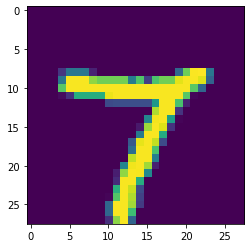

In [4]:
data_iter = iter(train_loader)
images, labels = data_iter.next()

print(images.shape)
print(labels.shape)

plt.imshow(images[0].squeeze())

In [5]:
lenet = networks.LeNet()
print(lenet)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [6]:
iternet = networks.IterNet(iter_depth=2)
print(iternet)

IterNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (input): Linear(in_features=256, out_features=120, bias=True)
  (iterative): Linear(in_features=120, out_features=120, bias=True)
  (out): Linear(in_features=120, out_features=10, bias=True)
)


In [7]:
model_parameters = filter(lambda p: p.requires_grad, lenet.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

print(params)

44426


In [8]:
model_parameters = filter(lambda p: p.requires_grad, iternet.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

print(params)

49142


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [10]:
TRIALS = 7
EPOCHS = 10

In [ ]:
time_0 = time.time()
_, LN_Accuracies, _ = train.trial_evaluation(TRIALS, EPOCHS, loaders, 'LeNet', device, verbose=True)
time_elapsed = time.time()-time_0
print("Total: {:.2f}\tAverage: {:.2f}".format(time_elapsed, time_elapsed/TRIALS))

In [ ]:
time_0 = time.time()
_, IN2_Accuracies, _ = train.trial_evaluation(TRIALS, EPOCHS, loaders, 'IterNet', device, verbose=True)
time_elapsed = time.time()-time_0
print("Total: {:.2f}\tAverage: {:.2f}".format(time_elapsed, time_elapsed/TRIALS))

In [ ]:
time_0 = time.time()
_, IN3_Accuracies, _ = train.trial_evaluation(TRIALS, EPOCHS, loaders, 'IterNet', device, iter_depth=3, verbose=False)
time_elapsed = time.time()-time_0
print("Total: {:.2f}\tAverage: {:.2f}".format(time_elapsed, time_elapsed/TRIALS))

In [ ]:
time_0 = time.time()
_, IN1_Accuracies, _ = train.trial_evaluation(TRIALS, EPOCHS, loaders, 'IterNet', device, iter_depth=1, verbose=False)
time_elapsed = time.time()-time_0
print("Total: {:.2f}\tAverage: {:.2f}".format(time_elapsed, time_elapsed/TRIALS))

In [ ]:
IN1_Accuracies = np.array(IN1_Accuracies)

print("Max: ", np.max(IN1_Accuracies))
print("Min: ", np.min(IN1_Accuracies))
print("Mean: ", np.mean(IN1_Accuracies))
print("SDev: ", np.std(IN1_Accuracies))

In [ ]:
IN2_Accuracies = np.array(IN2_Accuracies)

print("Max: ", np.max(IN2_Accuracies))
print("Min: ", np.min(IN2_Accuracies))
print("Mean: ", np.mean(IN2_Accuracies))
print("SDev: ", np.std(IN2_Accuracies))

In [ ]:
IN3_Accuracies = np.array(IN3_Accuracies)

print("Max: ", np.max(IN3_Accuracies))
print("Min: ", np.min(IN3_Accuracies))
print("Mean: ", np.mean(IN3_Accuracies))
print("SDev: ", np.std(IN3_Accuracies))

In [ ]:
LN_Accuracies = np.array(LN_Accuracies)

print("Max: ", np.max(LN_Accuracies))
print("Min: ", np.min(LN_Accuracies))
print("Mean: ", np.mean(LN_Accuracies))
print("SDev: ", np.std(LN_Accuracies))